In [23]:
import pandas as pd
df = pd.read_csv("/home/spatialuser/uribe/mapmetadata/jakarta2_inf_metadata_4.csv")
df

,u,v,k,osmid,inf_oneway,osm_oneway,inf_exp_speed,inf_speed_limit,osm_maxspeed
0,12031802470,6530720661,0,32123041,False,True,69.335,730,NaN
1,6530720663,6530720662,0,695530942,False,True,39.401,70,NaN
2,6530720662,6530720661,0,695530942,True,True,19.854,60,NaN
3,6530720661,12031802471,0,32123041,False,True,32.667,530,NaN
4,5487692131,5751220322,0,32123041,False,True,30.797,110,NaN
...,...,...,...,...,...,...,...,...,...
874,5487692053,3623791028,0,30288385,True,False,18.124,40,NaN
875,3623791028,5487692053,0,30288385,True,False,21.879,40,NaN
876,3623791029,5487692053,0,30288385,True,False,17.650,30,NaN
877,7129070410,3623791029,0,356981562,True,False,24.647,50,NaN


In [24]:
accuracy = (df['inf_oneway'] == df['osm_oneway']).mean()
accuracy

0.4527872582480091

In [25]:
def resolve_oneway(group):
    if False in group.values:
        return False
    elif True in group.values:
        return True
    else:
        return False
# Group by 'osmid' and apply logic to 'oneway'
result = df.groupby('osmid')['inf_oneway'].apply(resolve_oneway).reset_index()


In [26]:
result

,osmid,inf_oneway
0,28789395,False
1,28789401,False
2,29020408,True
3,29020409,False
4,29020425,True
...,...,...
216,1299936666,False
217,1299936667,True
218,1299936670,True
219,1299936671,True


In [27]:
def resolve_oneway_osm(group):
    if False in group.values:
        return False
    elif True in group.values:
        return True
    else:
        return None

agg_result = df.groupby('osmid').agg({
    'inf_oneway': resolve_oneway,
    'osm_oneway': resolve_oneway_osm
}).reset_index()

agg_result

,osmid,inf_oneway,osm_oneway
0,28789395,False,True
1,28789401,False,True
2,29020408,True,False
3,29020409,False,False
4,29020425,True,True
...,...,...,...
216,1299936666,False,True
217,1299936667,True,True
218,1299936670,True,True
219,1299936671,True,False


In [28]:
accuracy = (df['inf_oneway'] == df['osm_oneway']).mean()
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4528


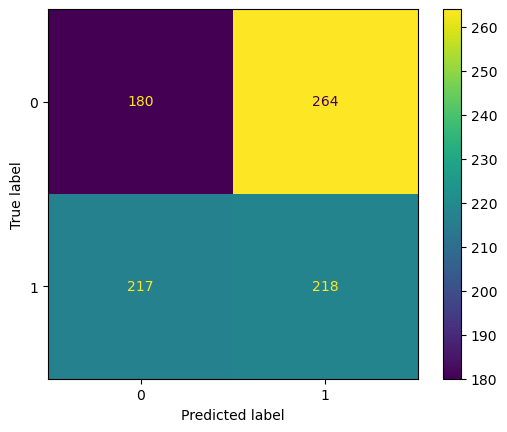

In [29]:
import sklearn.metrics as skl

cm = skl.confusion_matrix(list(df['osm_oneway']), list(df['inf_oneway']))
cm_display = skl.ConfusionMatrixDisplay(cm)
cm_display.plot()